Using the loan data that is already separated to two sets **train** and **test**, I will show some data visualizations and try to prove several arguments, including:
1. Correlation between loan amount with features *Gender, ApplicantIncome, Credit_History, Self_Employed, Dependents*
..
1. Classification with Logistic Regression and Random Forest to predict Loan Status from Income, Gender, and Dependents

First, I'm going to import libraries I'm going to use in this notebook.

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as lm
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import mode

# Reading the data and store it in variable 'test' and 'train'
test = pd.read_csv('test_lAUu6dG.csv')
train = pd.read_csv('train_ctrUa4K.csv')

In [2]:
# Top 5 rows of the data
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


By using the .head() command, we can see that there is a NaN cell under the **Credit_History** column. We want to find out if there are more NaN values in other columns for both test and train data.

*pandas_profiling* library is useful in getting the general idea about the data, including number of variables, percentage of missing entries, statistical summary that you can also get by using *.describe()* command for numerical columns, correlations matrix of variables. I can fill the missing values with mean or median of the column, but in this case, since the most missing values coming from **Credit_History** column (which is categorical, 0 or 1), I will eliminate rows containing missing values instead.

I can also see that we have 6 categorical columns. I'm planning to test machine learning algorithm on this data set, so I'll make some changes to tidy the data:
1. Rename some columns name by removing the underscore **_** 
1. Change most columns from categorical to int64:
    1. **Dependents**:  as it already contains integer 0, 1, and 2, I will change the type of columns to int64
    1. **Education**: Graduate to 1 and not graduate to 0
    1. **Gender**: Male to 1 and female to 0
    1. **Married**: Yes to 1 and no to 0
    1. **Property_Area**: Urban to 2, Semiurban to 1, and Rural to 0
    1. **Self_employed**: No to 1 and yes to 0


I see that **train** data frame has 13 columns, while **test** has only 12 columns. There is additional **Loan_Status** column with **train** data frame.

# Cleaning the data

As promised, let's start cleaning and shaping the data. Easy thing first: rename some columns name by removing the underscore **_** 

In [3]:
train.columns = ['LoanID', 'Gender', 'Married', 'Dependents', 'Education',
                 'SelfEmployed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
                 'LoanAmountTerm', 'CreditHistory', 'PropertyArea', 'LoanStatus']
test.columns = ['LoanID', 'Gender', 'Married', 'Dependents', 'Education',
                 'SelfEmployed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
                 'LoanAmountTerm', 'CreditHistory', 'PropertyArea']
print('Train columns: ', train.columns)
print('Test columns: ', test.columns)

Train columns:  Index(['LoanID', 'Gender', 'Married', 'Dependents', 'Education',
       'SelfEmployed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'LoanAmountTerm', 'CreditHistory', 'PropertyArea', 'LoanStatus'],
      dtype='object')
Test columns:  Index(['LoanID', 'Gender', 'Married', 'Dependents', 'Education',
       'SelfEmployed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'LoanAmountTerm', 'CreditHistory', 'PropertyArea'],
      dtype='object')


Now, the harder part: change most columns from categorical to int64:
1. **Dependents**:  as it already contains integer 0, 1, and 2, I will change the type of columns to int64
1. **Education**: Graduate to 1 and not graduate to 0
1. **Gender**: Male to 1 and female to 0
1. **Married**: Yes to 1 and no to 0
1. **Property_Area**: Urban to 2, Semiurban to 1, and Rural to 0
1. **Self_employed**: No to 1 and yes to 0

In [4]:
test['LoanStatus'] = 0
trainTotal = train.append(test)

I just appended the **test** data set to **train**, making a new data set **trainNew**, so it will be easier to tidy the data, and later to separate the data again. To do:
1. Correlation of CreditHistory and LoanStatus is almost 1 so I'm filling the missing values in CreditHistory column with median. Missing values for this column accounts for roughly 9%.
1. trim the NaN rows

In [8]:
trainTotal['CreditHistory'] = trainTotal['CreditHistory'].fillna(trainTotal['CreditHistory'].median())
trainTotal['Gender'].fillna(mode(trainTotal['Gender'].astype('str')).mode[0], inplace=True)
trainTotal['Married'].fillna(mode(trainTotal['Married'].astype('str')).mode[0], inplace=True)
trainTotal['SelfEmployed'].fillna(mode(trainTotal['SelfEmployed'].astype('str')).mode[0], inplace=True)
trainTotal['LoanAmount'].fillna(trainTotal['LoanAmount'].median(),inplace=True)

*Example of using lambda*

df['Size'] = df['Size'].apply(lambda x: str(x).replace('M','') if 'M' in str(x) else x)  
df['Size'] = df['Size'].apply(lambda x: float(str(x).replace('k',''))/1e3 if 'k' in str(x) else x)

In [10]:
pd.crosstab(train["CreditHistory"],train["LoanStatus"],margins=True, normalize='index')#.apply(lambda r: r/r.sum(), axis=1)

LoanStatus,N,Y
CreditHistory,,
0.0,0.921348,0.078652
1.0,0.204211,0.795789
All,0.317376,0.682624


In [11]:
objTrainTotal = trainTotal.select_dtypes(include='object').copy()

In [13]:
objTrainTotal.iloc[:,1:8].replace(regex = {'Male':1, 'Female':0, 
                              'Yes':1, 'No':0,
                              '3+':3,
                              'Graduate':1, 'Not Graduate':0,
                              'Semiurban':2, 'Urban':1, 'Rural':0,
                              'N':0, 'Y':1},inplace=True)
objTrainTotal['Dependents'].fillna(objTrainTotal['Dependents'].median(),inplace=True)

In [14]:
ott1 = objTrainTotal.iloc[:,1:8]
ottColumns = ott1.columns
for x in ottColumns:
    ott1[x] = pd.to_numeric(ott1[x])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [15]:
nonObjTrainTotal = trainTotal.select_dtypes(exclude='object').copy()
trainTotal = pd.concat([objTrainTotal.iloc[:,0],ott1, nonObjTrainTotal], axis=1)
trainTotal.head()

,LoanID,Gender,Married,Dependents,Education,SelfEmployed,PropertyArea,LoanStatus,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory
0,LP001002,1,0,0.0,1,0,1,1,5849,0.0,126.0,360.0,1.0
1,LP001003,1,1,1.0,1,0,0,0,4583,1508.0,128.0,360.0,1.0
2,LP001005,1,1,0.0,1,1,1,1,3000,0.0,66.0,360.0,1.0
3,LP001006,1,1,0.0,0,0,1,1,2583,2358.0,120.0,360.0,1.0
4,LP001008,1,0,0.0,1,0,1,1,6000,0.0,141.0,360.0,1.0


In [ ]:
pandas_profiling.ProfileReport(trainTotal)

In [16]:
# Separate the data into train and test again

train1 = trainTotal[trainTotal.LoanID.isin(train.LoanID)]
test1 = trainTotal[trainTotal.LoanID.isin(test.LoanID)]
print(np.array([['Train','Test'],[len(train),len(test)]]))
print(np.array([['Train1','Test1'],[len(train1),len(test1)]]))

[['Train' 'Test']
 ['614' '367']]
[['Train1' 'Test1']
 ['614' '367']]


In [ ]:
pandas_profiling.ProfileReport(train1)

In [44]:
x_train = train1[['LoanAmount','CreditHistory']]
y_train = train1['LoanStatus']
x_test = test1[['LoanAmount','CreditHistory']]
y_test = test1['LoanStatus']

# Decision Tree

In [45]:
tree = DecisionTreeClassifier().fit(x_train,y_train)

In [46]:
tree.feature_importances_

array([0.50877349, 0.49122651])

In [47]:
y_test = tree.predict(x_test)

# Gaussian Process

In [49]:
from sklearn.gaussian_process import GaussianProcessClassifier

In [53]:
gauss = GaussianProcessClassifier().fit(x_train, y_train)
y_gauss = gauss.predict(x_test)

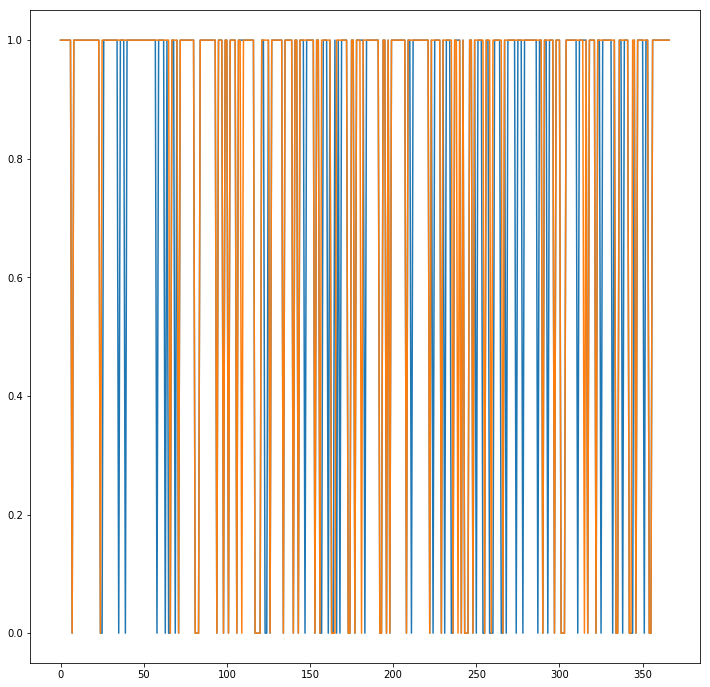

In [51]:
%matplotlib inline
plt.figure(figsize=(12,12))
plt.plot(y_test)
plt.plot(y_gauss)
plt.show()

# Exporting Result

In [52]:
yTest = pd.DataFrame(y_test)
submit = pd.DataFrame(pd.concat([test['LoanID'],yTest], axis = 1))
submit.columns = ['Loan_ID','Loan_Status']
submit['Loan_Status'] = submit['Loan_Status'].apply(lambda x: str(x).replace('1','Y') if '1' in str(x) else 'N')
submit.to_csv(path_or_buf='submission.csv', index=False)